# One-Dimensional Hopper

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [15]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib.
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

In [16]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# pydrake imports
from pydrake.all import (MultibodyPlant, AddMultibodyPlantSceneGraph,
                         DiagramBuilder, Parser, VectorSystem, SignalLogger,
                         Simulator, PlanarSceneGraphVisualizer, Multiplexer,
                         plot_system_graphviz, MatrixGain)

# underactuated imports
from underactuated import FindResource

## Problem Description

In this notebook we synthesize a controller for the one dimensional hopper depicted in the figure below.
This is a simplified model of the hopper analyzed in Marc Raibert's paper "[Hopping in legged systems - Modeling and simulation for the two-dimensional one-legged case](https://ieeexplore.ieee.org/abstract/document/6313238)".
Even though we reported below all the mathematical derivations you need to complete this exercise, you're encouraged to read the paper!

<img src="https://raw.githubusercontent.com/RussTedrake/underactuated/master/figures/exercises/one_d_hopper.jpg" width="500">

The hopper is composed of two rigid links: the **body** and the **leg**, with mass $m_{\mathrm{b}}$ and $m_{\mathrm{l}}$, respectively.
These are connected by an elastic prismatic joint.
The joint spring has stiffness $k$ and can be compressed in two ways: by moving the hopper foot towards the body (i.e. increasing $l (t) = z_{\mathrm{l}} (t) - z_{\mathrm{b}} (t)$), or by increasing the preload $\delta (t)$, which is our (nonnegative) control variable.
The total compression of the spring is $l (t) + \delta (t)$, and the figure in the left below depicts the spring at rest.

The control task is to make the system hop at a given height $h$.
We will accomplish this via a careful analysis of the system energy in the various phases of the hopping cycle.

Besides understanding the physics of this system, in this notebook you are asked to complete two pieces of code:
- A function that computes the hopper energy given its state.
- The hopping controller which sets the preload $\delta (t)$ based on the measurement of the hopper state.

In the following cell we wrote a convenient function to access the physical parameters of the hopper.

In [17]:
def get_hopper_parameters():
    
    # spring stiffness (not in the urdf)
    k = 1000
    
    # parse urdf
    hopper = MultibodyPlant(time_step=0)
    urdf_path = FindResource('models/one_d_hopper.urdf')
    Parser(hopper).AddModelFromFile(urdf_path)
    hopper.Finalize()
    
    # retrieve physical parameters
    mb = hopper.GetBodyByName('body').default_mass()
    ml = hopper.GetBodyByName('leg').default_mass()
    g = - hopper.gravity_field().gravity_vector()[-1]
    
    return k, mb, ml, g

## The Hopping Cycle

Let's analyze the four phases of the hopping cycle illustrated below.
We start from the **touchdown** instant $t_{\mathrm{td}}$ (i.e. the transition from the flight phase to the stance phase).
For the moment we assume $\delta (t)$ to be a nonnegative constant for all $t$ (zero in the figure).

At touchdown the leg has an impact with the ground and $z_{\mathrm{l}} (t_{\mathrm{td}}) = 0$.
We assume this impact to be inelastic, i.e., the leg does not bounce back after the collision.
In math: $\dot z_{\mathrm{l}} (t_{\mathrm{td}}^+) = 0$, where $t_{\mathrm{td}}^+$ denotes the instant of time immediately after touchdown.
Because of the spring between the leg and the body, the impulse is not transmitted to the body which continues its descent with the same velocity $\dot z_{\mathrm{b}} (t_{\mathrm{td}}^+) = \dot z_{\mathrm{b}} (t_{\mathrm{td}}^-) < 0$.

During stance, the leg is pushed towards the ground by the spring force (and gravity) hence, given that $\dot z_{\mathrm{l}} (t_{\mathrm{td}}^+) = 0$, the leg-ground contact cannot be broken: $z_{\mathrm{l}} (t) = \dot z_{\mathrm{l}} (t) = 0$ for all $t$ during stance.
In contrast, the body first moves towards the ground, and then moves up towards the the hard stop of the prismatic joint.
We call **bottom** the moment during stance when the body has minimum altitude and zero velocity, and we denote it as $t_{\mathrm{bt}}$.

When the body reaches the prismatic-joint hard stop, we have a second inelastic collision.
We call this instant **lift off**, denoted as $t_{\mathrm{lo}}$, since this impact between the body and the hard stop makes the leg lift off the ground.
An instant after this inelastic collision, the body and the leg have the same velocity $\dot z_{\mathrm{b}} (t_{\mathrm{lo}}^+) = \dot z_{\mathrm{l}} (t_{\mathrm{lo}}^+)$.

The flying phase starts after lift off.
Our goal is to ensure that at the time $t_{\mathrm{ap}}$, when the body is at the **apex** of its trajectory, we have $z_{\mathrm{l}} (t_{\mathrm{ap}}) = z_{\mathrm{b}} (t_{\mathrm{ap}}) = h$.
Note that, during flight, there is no reason for the body to break contact with the hard stop and $l(t)$ is constantly zero.
In fact, in the flight phase, the body and the leg have the same initial velocity (the one after lift off), they are both subject to the same acceleration (gravity), and the spring can only push them together (if $\delta (t) > 0$).

<img src="https://raw.githubusercontent.com/RussTedrake/underactuated/master/figures/exercises/one_d_hopping_cycle.jpg" width="800">

## The Controller

The inelastic impacts we have at touchdown $t_{\mathrm{td}}$ and lift off $t_{\mathrm{lo}}$ cause two drops in the system energy.
The goal of the controller is to inject energy in the system to balance these losses, and ensure that the hopping height is exactly $h$.
We achieve this by increasing the preload $\delta (t)$ or, in other words, by increasing the potential energy stored in the spring.

The plan is to modify the spring preload $\delta(t)$ only twice per hopping cycle:
- At bottom time $t_{\mathrm{bt}}$ we set the preload to $\delta (t_{\mathrm{bt}}^+) = \bar \delta \geq 0$, with $\bar \delta$ chosen so that the hopping height is exactly $h$.
- At apex time $t_{\mathrm{ap}}$ we reset the preload to $\delta (t_{\mathrm{ap}}^+) = 0$.

To choose the correct value of $\bar \delta$, we will analyze the energy fluctuations during the hopping cycle.
First, however, let's do some coding to be able to run a simulation.

## The Spring Block in the Diagram

In this notebook we "cheat" a bit and, instead of having a true spring between the body and the leg directly in the `urdf` file of the hopper, we mimic the elastic force using an actuator between these bodies.
(This makes the logic behind the variable preload much easier to code.)
This actuator is called `spring` and is one of the blocks in the diagram below.
As inputs, it receives the `hopper` state and the preload $\delta(t)$ from the `preload_controller`.
As output, it sends the spring force $- k [l(t) + \delta(t)]$ to the `hopper`.

In [18]:
class Spring(VectorSystem):

    def __init__(self):
        
        # 5 inputs: hopper state and spring preload delta
        # 1 output: spring force
        VectorSystem.__init__(self, 5,  1)
        
        # spring stiffness
        self.k = get_hopper_parameters()[0]

    # note that this function is called at each time step
    def DoCalcVectorOutput(self, context, state_delta, unused, spring_force):
        
        # set the output of the spring block to
        # the value of the elastic force
        l = state_delta[1]
        delta = state_delta[4]
        spring_force[:] = [- self.k * (l + delta)]

## The Block Diagram and the Simulator

We now write a couple of function to build the block diagram and setup a simulation environment.
These take the argument `preload_controller` which is the controller we will synthesize later in the notebook.
For the moment, we just need to know that `preload_controller` takes the hopper state and returns the preload $\delta(t)$.

In [19]:
def build_block_diagram(preload_controller):

    # initialize block diagram
    builder = DiagramBuilder()

    # instantiate plant and scene graph
    # the nonzero time_step is more robust in the handling
    # of collisions and simplifies control synthesis (wrt time_step=0)
    hopper, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)

    # parse the hopper urdf
    urdf_path = FindResource('models/one_d_hopper.urdf')
    Parser(hopper).AddModelFromFile(urdf_path)
    hopper.Finalize()
    hopper.set_name('hopper')
    
    # controller for the spring preload
    # wire hopper -> controller
    preload_controller = builder.AddSystem(preload_controller)
    builder.Connect(hopper.get_state_output_port(), preload_controller.get_input_port(0))
    
    # mux to merge the hopper state and the preload in a single cable
    # wire hopper -> mux and controller -> mux
    mux = builder.AddSystem(Multiplexer([4, 1]))
    builder.Connect(hopper.get_state_output_port(), mux.get_input_port(0))
    builder.Connect(preload_controller.get_output_port(0), mux.get_input_port(1))
    mux.set_name('mux')
    
    # block that mimics the spring
    # wire mux -> spring and spring -> hopper
    spring = builder.AddSystem(Spring())
    builder.Connect(mux.get_output_port(0), spring.get_input_port(0))
    builder.Connect(spring.get_output_port(0), hopper.get_actuation_input_port())
    spring.set_name('spring')
    
    # logger that records the hopper state and the preload
    logger = builder.AddSystem(SignalLogger(5))
    builder.Connect(mux.get_output_port(0), logger.get_input_port(0))
    logger.set_name('logger')

    # visualizer for the MultibodyPlant
    # wire scene_graph -> visualizer
    visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(
        scene_graph,
        xlim=[-1, 1],
        ylim=[-.2, 2.5],
        show=False
    ))
    builder.Connect(scene_graph.get_pose_bundle_output_port(), visualizer.get_input_port(0))
    visualizer.set_name('visualizer')

    # finalize block diagram
    diagram = builder.Build()
    
    return diagram

Just to be sure that we wired things correctly, let's plot the block diagram.

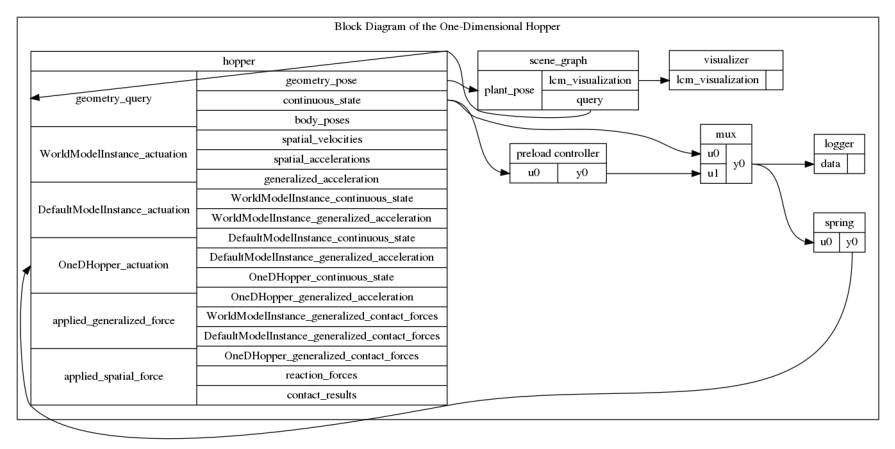

In [20]:
# dummy controller just to build the diagram for the plot
preload_controller = MatrixGain(np.zeros((1, 4)))
preload_controller.set_name('preload controller')

# plot block diagram
plt.figure(figsize=(20, 8))
diagram = build_block_diagram(preload_controller)
diagram.set_name('Block Diagram of the One-Dimensional Hopper')
plot_system_graphviz(diagram)

The final piece of code before we can see the hopper moving is the simulator.

In [21]:
def simulate(initial_state, duration, preload_controller):
    
    # get diagram
    diagram = build_block_diagram(preload_controller)

    # start recording the video for the animation of the simulation
    visualizer = diagram.GetSubsystemByName('visualizer')
    visualizer.start_recording()

    # set up a simulator
    simulator = Simulator(diagram)
    simulator.set_publish_every_time_step(False)

    # set the initial conditions
    hopper = diagram.GetSubsystemByName('hopper')
    simulator_context = simulator.get_mutable_context()
    hopper_context = diagram.GetMutableSubsystemContext(hopper, simulator_context)
    hopper.SetPositionsAndVelocities(hopper_context, initial_state)

    # simulate from zero to duration
    simulator.Initialize()
    simulator.AdvanceTo(duration)

    # stop the video and build the animation
    visualizer.stop_recording()
    animation = visualizer.get_recording_as_animation()

    return animation, diagram.GetSubsystemByName('logger')

## Hopper Mechanical Energy

We can now start the energy analysis of the hopping cycle.
The total mechanical energy stored in the hopper at a generic time $t$ has three components (kinetic, gravitational, and elastic), and is given by
$$
E(t)
=
\frac{1}{2} m_{\mathrm{b}} \dot z_{\mathrm{b}}^2 (t)
+
\frac{1}{2} m_{\mathrm{l}} \dot z_{\mathrm{l}}^2 (t)
+
m_{\mathrm{b}} g z_{\mathrm{b}} (t)
+
m_{\mathrm{l}} g z_{\mathrm{l}} (t)
+
\frac{1}{2} k [l (t) + \delta(t)]^2.
$$
Where $l (t) = z_{\mathrm{l}} (t) - z_{\mathrm{b}} (t)$ is always nonnegative because of the hard limit of the prismatic joint.

To support our analysis with a plot, in the next cell you are asked to write a function that computes the mechanical energy $E(t)$ given the `state` of the hopper, and the preload `delta` of the spring.

Notice that:
- We decided to represent the hopper state with $[z_{\mathrm{b}}, l, \dot z_{\mathrm{b}}, \dot l]^T$.
- The function `mechanical_energy` should accept scalars, but also vectorized inputs coming from the logger. If we pass a $4 \times N$ array for the `state` and an $N$ array for `delta`, with $N$ number of time steps in the simulation, we want `E` to be an $N$ array.

In [22]:
def mechanical_energy(state, delta):
    
    # unpack parameters and state
    k, mb, ml, g = get_hopper_parameters()
    zb, l, zb_dot, l_dot = state

    # (vectorized) mechanical energy of the hopper
    #E = np.zeros_like(delta) # modify here
    E = 0.5 * mb * (zb_dot**2) + 0.5 * ml * ((l_dot + zb_dot)**2) + mb*g*zb + ml*g*(l+zb) + 0.5*k*((l+delta)**2)
    return E

Let's simulate the hopper from the initial conditions $z_{\mathrm{b}} (0) = 1$ and $l (0) = \dot z_{\mathrm{b}} (0) = \dot l (0) = 0$ for a duration of 5 seconds.

Then, we plot the energy as a function of time.
This plot is just to have a grasp on the hopper physics: for the moment we run the simulation with the spring preload $\delta (t)$ set to zero for all times $t$.

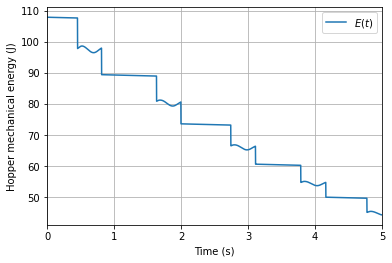

In [23]:
# simulation parameters
initial_state = [1, 0, 0, 0]
duration = 5

# function to ensure that at the given state
# there is not penetration between the rigid bodies
def raise_if_penetration(state):
    
    # ground contact
    if state[0] + state[1] < 0:
        raise ValueError('Leg in penetration with ground.')
        
    # hard limit of the prismatic joint
    if state[1] < 0:
        raise ValueError('Body in penetration with hard joint limit.')
        
# check initial state
raise_if_penetration(initial_state)

# set the preload to zero independently of the hopper state
preload_controller = MatrixGain(np.zeros((1, 4)))

# run the simulation
animation, logger = simulate(initial_state, duration, preload_controller)

# evaluate mechanical energy
time = logger.sample_times()
state = logger.data()[:4]
delta = logger.data()[4]
E = mechanical_energy(state, delta)

# plot mechanical energy
plt.figure()
plt.plot(time, E, label=r'$E(t)$')
plt.xlim(0, duration)
plt.xlabel('Time (s)')
plt.ylabel('Hopper mechanical energy (J)')
plt.grid(True)
plt.legend()

If you did thing correctly, the energy plot should look almost like a stair.
The energy is perfectly conserved when the hopper is in the flight phase (e.g. at time zero) and it has a drop at touchdown.
Energy is more or less preserved during stance (in the following we will assume that it is preserved exactly), and it has a second drop at lift off.

Once you're convinced about this behavior, we can start the derivation of the controller.

## Derivation of the Controller

A few cells above, we have said that the plan is to inject energy in the hopper during the bottom instant $t_{\mathrm{bt}}$.
And we noticed that we can do that by increasing the preload from zero to $\bar \delta$.
Now we answer the big question mark: what's the precise value of $\bar \delta$ such that at the next apex $t_{\mathrm{ap}}$ the hopper is at height $h$ from the ground?

We need some math to link the system energy at the bottom and the one at the apex.

### Energy Before and After the "Bottom"

At the bottom instant $t_{\mathrm{bt}}$ we have:
- Leg steady in contact with the ground: $z_{\mathrm{l}} (t_{\mathrm{bt}}) = \dot z_{\mathrm{l}} (t_{\mathrm{bt}}) = 0$.
- Body steady in (unknown but measured) position: $z_{\mathrm{b}} (t_{\mathrm{bt}}) < 0$ and $\dot z_{\mathrm{b}} (t_{\mathrm{bt}}) = 0$.
- Preload moving from zero to the value to be decided: $\delta (t_{\mathrm{bt}}^-) = 0$ and $\delta (t_{\mathrm{bt}}^+)  = \bar \delta \geq 0$.

Just before the preload of the spring, the energy of the system is
$$
E(t_{\mathrm{bt}}^-)
=
m_{\mathrm{b}} g z_{\mathrm{b}} (t_{\mathrm{bt}})
+
\frac{1}{2} k z_{\mathrm{b}}^2 (t_{\mathrm{bt}}),
$$
where we used $l(t_{\mathrm{bt}}) = - z_{\mathrm{b}} (t_{\mathrm{bt}})$.
Compressing instantaneously the spring by $\bar \delta$, we have an energy increase
\begin{align}
E(t_{\mathrm{bt}}^+)
& =
m_{\mathrm{b}} g z_{\mathrm{b}} (t_{\mathrm{bt}})
+
\frac{1}{2} k [\bar \delta - z_{\mathrm{b}} (t_{\mathrm{bt}})]^2
\\
& =
m_{\mathrm{b}} g z_{\mathrm{b}} (t_{\mathrm{bt}})
+
\frac{1}{2} k \bar \delta^2
+
\frac{1}{2} k z_{\mathrm{b}}^2 (t_{\mathrm{bt}})
-
k \bar \delta z_{\mathrm{b}} (t_{\mathrm{bt}}).
\end{align}
We need to understand what's the right amount of preload $\bar \delta$ to make the system hop at height $h$.

### Energy Before "Lift Off"

At the lift off time $t_{\mathrm{lo}}$ (transition from stance to flight) we have:
- Leg in contact with the ground, which has an instantaneous velocity increase due to the impact: $z_{\mathrm{l}} (t_{\mathrm{lo}}) = \dot z_{\mathrm{l}} (t_{\mathrm{lo}}^-) = 0$ and $\dot z_{\mathrm{l}} (t_{\mathrm{lo}}^+) > 0$.
- Body in contact with the hard stop, which has an instantaneous velocity decrease: $z_{\mathrm{b}} (t_{\mathrm{lo}}) = 0$ and $0 < \dot z_{\mathrm{b}} (t_{\mathrm{lo}}^+) < \dot z_{\mathrm{b}} (t_{\mathrm{lo}}^-)$.
- Preload equal to the value to be decided: $\delta (t_{\mathrm{lo}}) = \bar \delta$.

Just before lift off, the energy is
$$
E(t_{\mathrm{lo}}^-)
=
\frac{1}{2} m_{\mathrm{b}} \dot z_{\mathrm{b}}^2 (t_{\mathrm{lo}}^-)
+
\frac{1}{2} k \bar \delta^2.
$$
Since energy is (almost) preserved between $t_{\mathrm{bt}}^+$ and $t_{\mathrm{lo}}^-$, equating $E(t_{\mathrm{bt}}^+)$ and $E(t_{\mathrm{lo}}^-)$ we get the kinetic energy before lift off as a function of $\bar \delta$:
$$
\frac{1}{2} m_{\mathrm{b}} \dot z_{\mathrm{b}}^2 (t_{\mathrm{lo}}^-)
=
m_{\mathrm{b}} g z_{\mathrm{b}} (t_{\mathrm{bt}})
+
\frac{1}{2} k z_{\mathrm{b}}^2 (t_{\mathrm{bt}})
-
k \bar \delta z_{\mathrm{b}} (t_{\mathrm{bt}}).
$$

### "Lift-Off" Impact

Momentum is preserved during impacts.
This allows to derive the velocity of the leg and the body just after lift off.
We have
$$
m_{\mathrm{b}} \dot z_{\mathrm{b}} (t_{\mathrm{lo}}^-)
=
m_{\mathrm{b}} \dot z_{\mathrm{b}} (t_{\mathrm{lo}}^+)
+
m_{\mathrm{l}} \dot z_{\mathrm{l}} (t_{\mathrm{lo}}^+).
$$
If we model the collision as inelastic (not too far from reality and from what Drake does), the leg and the body will stick together after lift off.
Thus, we obtain
$$
\dot z_{\mathrm{b}} (t_{\mathrm{lo}}^+)
=
\dot z_{\mathrm{l}} (t_{\mathrm{lo}}^+)
=
\frac{m_{\mathrm{b}}}{m_{\mathrm{b}} + m_{\mathrm{l}}}
\dot z_{\mathrm{b}} (t_{\mathrm{lo}}^-).
$$

### Energy After "Lift Off"

Just after lift off, the body sticks to the leg and the energy is
$$
E(t_{\mathrm{lo}}^+)
=
\frac{1}{2} (m_{\mathrm{b}} + m_{\mathrm{l}}) \dot z_{\mathrm{b}}^2 (t_{\mathrm{lo}}^+)
+
\frac{1}{2} k \bar \delta^2,
$$
Using the conservation of momentum at lift off, we obtain
$$
E(t_{\mathrm{lo}}^+)
=
\frac{1}{2} 
\frac{m_{\mathrm{b}}^2}{m_{\mathrm{b}} + m_{\mathrm{l}}}
\dot z_{\mathrm{b}}^2 (t_{\mathrm{lo}}^-)
+
\frac{1}{2} k \bar \delta^2.
$$
Moreover, from the conservation of energy between bottom and lift off, we get
$$
E(t_{\mathrm{lo}}^+)
=
\frac{m_{\mathrm{b}}}{m_{\mathrm{b}} + m_{\mathrm{l}}}
\left[
m_{\mathrm{b}} g z_{\mathrm{b}} (t_{\mathrm{bt}})
+
\frac{1}{2} k z_{\mathrm{b}}^2 (t_{\mathrm{bt}})
-
k \bar \delta z_{\mathrm{b}} (t_{\mathrm{bt}})
\right]
+
\frac{1}{2} k \bar \delta^2.
$$

### Energy Before the "Apex"

At the apex $t_{\mathrm{ap}}$ we (want to) have:
- Leg fully extended with zero velocity: $z_{\mathrm{l}} (t_{\mathrm{ap}}) = h$ and $\dot z_{\mathrm{l}} (t_{\mathrm{ap}}) = 0$.
- Body in contact with the hard stop with zero velocity: $z_{\mathrm{b}} (t_{\mathrm{ap}}) = h$ and $\dot z_{\mathrm{b}} (t_{\mathrm{ap}}) = 0$.
- Reset the preload to zero, from the still unknown value $\bar \delta$: $\delta (t_{\mathrm{ap}}^-) = \bar \delta$ and $\delta (t_{\mathrm{ap}}^+) = 0$.

The energy just before the apex is
$$
E(t_{\mathrm{ap}}^-)
=
(m_{\mathrm{b}} + m_{\mathrm{l}}) g h
+
\frac{1}{2} k \bar \delta^2.
$$

Energy is preserved in the while flying, hence $E(t_{\mathrm{ap}}^-)$ must be equal to $E(t_{\mathrm{lo}}^+)$.
This gives
$$
(m_{\mathrm{b}} + m_{\mathrm{l}}) g h
=
\frac{m_{\mathrm{b}}}{m_{\mathrm{b}} + m_{\mathrm{l}}}
\left[
m_{\mathrm{b}} g z_{\mathrm{b}} (t_{\mathrm{bt}})
+
\frac{1}{2} k z_{\mathrm{b}}^2 (t_{\mathrm{bt}})
-
k \bar \delta z_{\mathrm{b}} (t_{\mathrm{bt}})
\right].
$$

Finally! This is a linear equation that allows to express the preload $\bar \delta$ as a function the hopping height $h$!
We get
$$
\bar \delta
=
\frac{1}{2} z_{\mathrm{b}} (t_{\mathrm{bt}})
+ \frac{m_{\mathrm{b}} g}{k}
- \frac{(m_{\mathrm{b}} + m_{\mathrm{l}})^2}{k m_{\mathrm{b}} z_{\mathrm{b}} (t_{\mathrm{bt}})} g h.
$$

Note that $\bar \delta$ could in principle result to be negative, when we have more energy than we need for the hop.
In that case, we just set $\bar \delta = 0$, and we let the impacts in the cycle pull energy out of the system until we arrive at the desired level.

### What Happens After the "Apex"?

Just after $t_{\mathrm{ap}}$, we reset the spring preload $\delta(t)$ to zero.
You can convince yourself that this does not have any impact in the motion of th hopper.
Before the apex the spring force is contrasted by the hard stop, the reset just zeroes this internal force.
(Consider drawing the free body diagram for the leg and the body separately if you find this hard to believe.)

The impact at touchdown can be analyzed similarly to the one at lift off (it is actually simpler) but, since it does not affect our control decision, we do not care about the details of what happens there.

## Simulate the Closed-Loop System

Finally we are ready to implement our controller!

In the next cell you are asked to implement the controller we just derived by working on the method `DoCalcVectorOutput` of the class `PreloadController`.
At each time step $t$, `DoCalcVectorOutput` must set the entry of its argument `delta` to the desired preload value $\delta(t)$.
To compute this value, you are allowed to use:
- `self.h`: the desired hopping height.
- `self.hopper_parameters`: the physical parameters of the hopper ($k$, $m_{\mathrm{b}}$, $m_{\mathrm{l}}$, and $g$).
- `state`: the hopper state $[z_{\mathrm{b}}, l, \dot z_{\mathrm{b}}, \dot l]^T$ at the current time step;
- `self.last_delta`: the preload $\delta(t)$ you set the last time `DoCalcVectorOutput` has been called (i.e. last time step).
- `self.last_state`: the hopper state at the last time step.

The implementation of this function is nontrivial.
Feel free to take the path you prefer to do that but, in case you feel lost, this is a sketch of our implementation.

We added two methods to the class `PreloadController`:
- `is_bottom_or_apex`. Using the `state` and the `last_state`, this method identifies if the current time step is the bottom $t_{\mathrm{bt}}$, the apex $t_{\mathrm{ap}}$, or neither of the two. This can be done, e.g., by checking if the velocity of the body $\dot z_{\mathrm{b}}$ changed sign from the last time step. Whereas, to distinguish between the bottom and the apex, you can look at the sign of the position of the body $z_{\mathrm{b}}$.
- `get_delta_bar`. Using `h`, the `hopper_parameters`, and the current `state`, this method computes the value of $\bar \delta$ using the formula derived above.

Finally, `DoCalcVectorOutput` calls first `is_bottom_or_apex`.
If the current time is the apex $t_{\mathrm{ap}}$, it sets the entry in `delta` to zero.
If the current time is the bottom $t_{\mathrm{bt}}$, it calls `get_delta_bar` and it sets `delta` to $\max(\bar \delta, 0)$ (remember that we want $\delta(t) \geq 0$).
If none of the previous, it sets `delta` to the `last_delta`.

In [24]:
import math

class PreloadController(VectorSystem):
    
    def __init__(self, h):
        
        # 4 inputs: hopper state
        # 1 output: spring preload
        VectorSystem.__init__(self, 4,  1)
        
        # desired hopping height
        self.h = h
        
        # store physical parameters of the hopper
        self.hopper_parameters = get_hopper_parameters()
        
        # the controller keeps track of the last value of
        # the preload and the last state of the hopper
        self.last_delta = 0
        self.last_state = np.full(4, np.nan)
    
    # note that this function is called at each time step
    def DoCalcVectorOutput(self, context, state, unused, delta):
        
        # troubleshooting: inside this class you must use self.h
        # (class attribute) and not h (global variable)
        h = self.h
        
        
        if self.is_bottom(state):
            delta[:] = [self.get_delta_bar(state)]
        elif self.is_apex(state):
            delta[:] = [0]
        else:
            delta[:] = [self.last_delta]
        
        #delta[:] = [0.05]
        
        # assign value of the preload at each time step
        #delta[:] = [0] # modify here
        
        # update controller internal memory
        self.last_delta = delta[0]
        self.last_state = state
        
    def is_bottom(self,state):
        k, mb, ml, g = get_hopper_parameters()
        zb, l, zb_dot, l_dot = state
        # zl == 0, zb_dot == 0
        zl = l + zb
        #return np.abs(zl) < 1e-2 and np.abs(zb_dot) < 1e-1
        return np.abs(zl) < 1e-1 and zb_dot*self.last_state[2] <= 0
        
    def is_apex(self,state):
        k, mb, ml, g = get_hopper_parameters()
        zb, l, zb_dot, l_dot = state
        # zl > 0 zl_dot == 0
        zl = l + zb
        zl_dot = l_dot + zb_dot
        return zl > 0 and np.abs(zl_dot) < 1e-2
        
    def get_delta_bar(self,state):
        k, mb, ml, g = get_hopper_parameters()
        zb, l, zb_dot, l_dot = state
        #zb = self.last_state[0]
        zb = max(state[0],self.last_state[0])
        dd = 0.5 * zb + mb*g/k - ((mb+ml)**2)*g*self.h/(k*mb*zb)
        return max(0,dd)
        
    # feel free to add methods to this class if you need to
    # modify here

Here you can test your work by playing with the initial conditions and the value of $h$.

In [25]:
# simulation parameters
initial_state = [.1, 0, 0, 0]
raise_if_penetration(initial_state)
duration = 5

# desired hopping height
h = 10

# synthesize the controller
preload_controller = PreloadController(h)

# run simulation
animation, logger = simulate(initial_state, duration, preload_controller)

## Animate and Plot the Simulation

In [26]:
# play the video
HTML(animation.to_jshtml())

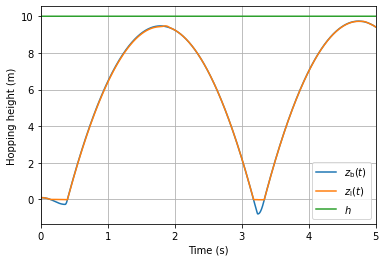

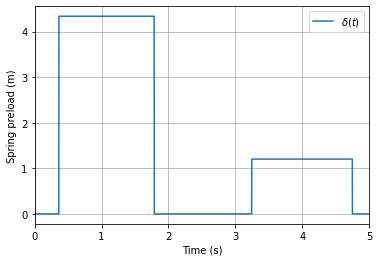

In [27]:
# unpack logger data
time = logger.sample_times()
state = logger.data()[:4]
delta = logger.data()[4]

# plot body position zb(t) and target value h
plt.figure()
plt.plot(time, state[0], label=r'$z_{\mathrm{b}}(t)$')
#plt.plot(time, state[1], label=r'$l(t)$')
plt.plot(time, state[0]+state[1], label=r'$z_{\mathrm{l}}(t)$')
#plt.plot(time, state[2], label=r'$\dot{zb}$')
#plt.plot(time, state[3], label=r'$\dot{l}$')
plt.plot(time, [h] * len(time), label=r'$h$')
plt.xlim(0, duration)
plt.xlabel('Time (s)')
plt.ylabel('Hopping height (m)')
plt.grid(True)
plt.legend()

# plot spring preload delta(t)
plt.figure()
plt.plot(time, delta, label=r'$\delta(t)$')
plt.xlim(0, duration)
plt.xlabel('Time (s)')
plt.ylabel('Spring preload (m)')
plt.grid(True)
plt.legend()

## Autograding
You can check your work by running the following cell.

In [28]:
from underactuated.exercises.simple_legs.one_d_hopper.test_one_d_hopper import TestOneDHopper
from underactuated.exercises.grader import Grader
Grader.grade_output([TestOneDHopper], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 13/13.

Score for Test mechanical energy is 3/3.

Score for Test preload controller is 10/10.
